In [1]:
from IPython.core.display import display, HTML
display(HTML("<style>.container { width:98% !important; }</style>"))

# Testing Warp Simulations of a Space Charge Neutralized Cooler
Notebook for analyzing the output of magnetized_cooler.py, which will simulate a small section of a space charge neutralized cooler which includes a background H2 gas being ionized by a passing electron beam (at ~3.2 MeV to match the ion beam velocity) in theory this will allow for very high current d.c. electron beam with the space charge neutralization reducing ExB forces that would reduce the cooling rate.
The current simulation is very rudimentary and designed more for basic testing of simulation elements such as electron beam injection and performance of the ionization calculations. It does not run long enough for fields to be perturbed by the ion production.
Physical setup is based on Kells 1979 Fermilab cooler design. 

Known ionization issues:
- It is possible for ionization products to be emitted at v>c, this happens only very rarely but does kill the simulation immediately (Warp checks for this). May be due to error in rsoopic module
- Cross section is small, right now the gas pressure used in simulation is unrealistically high just to get a reasonable rate of production (still pretty slow though)


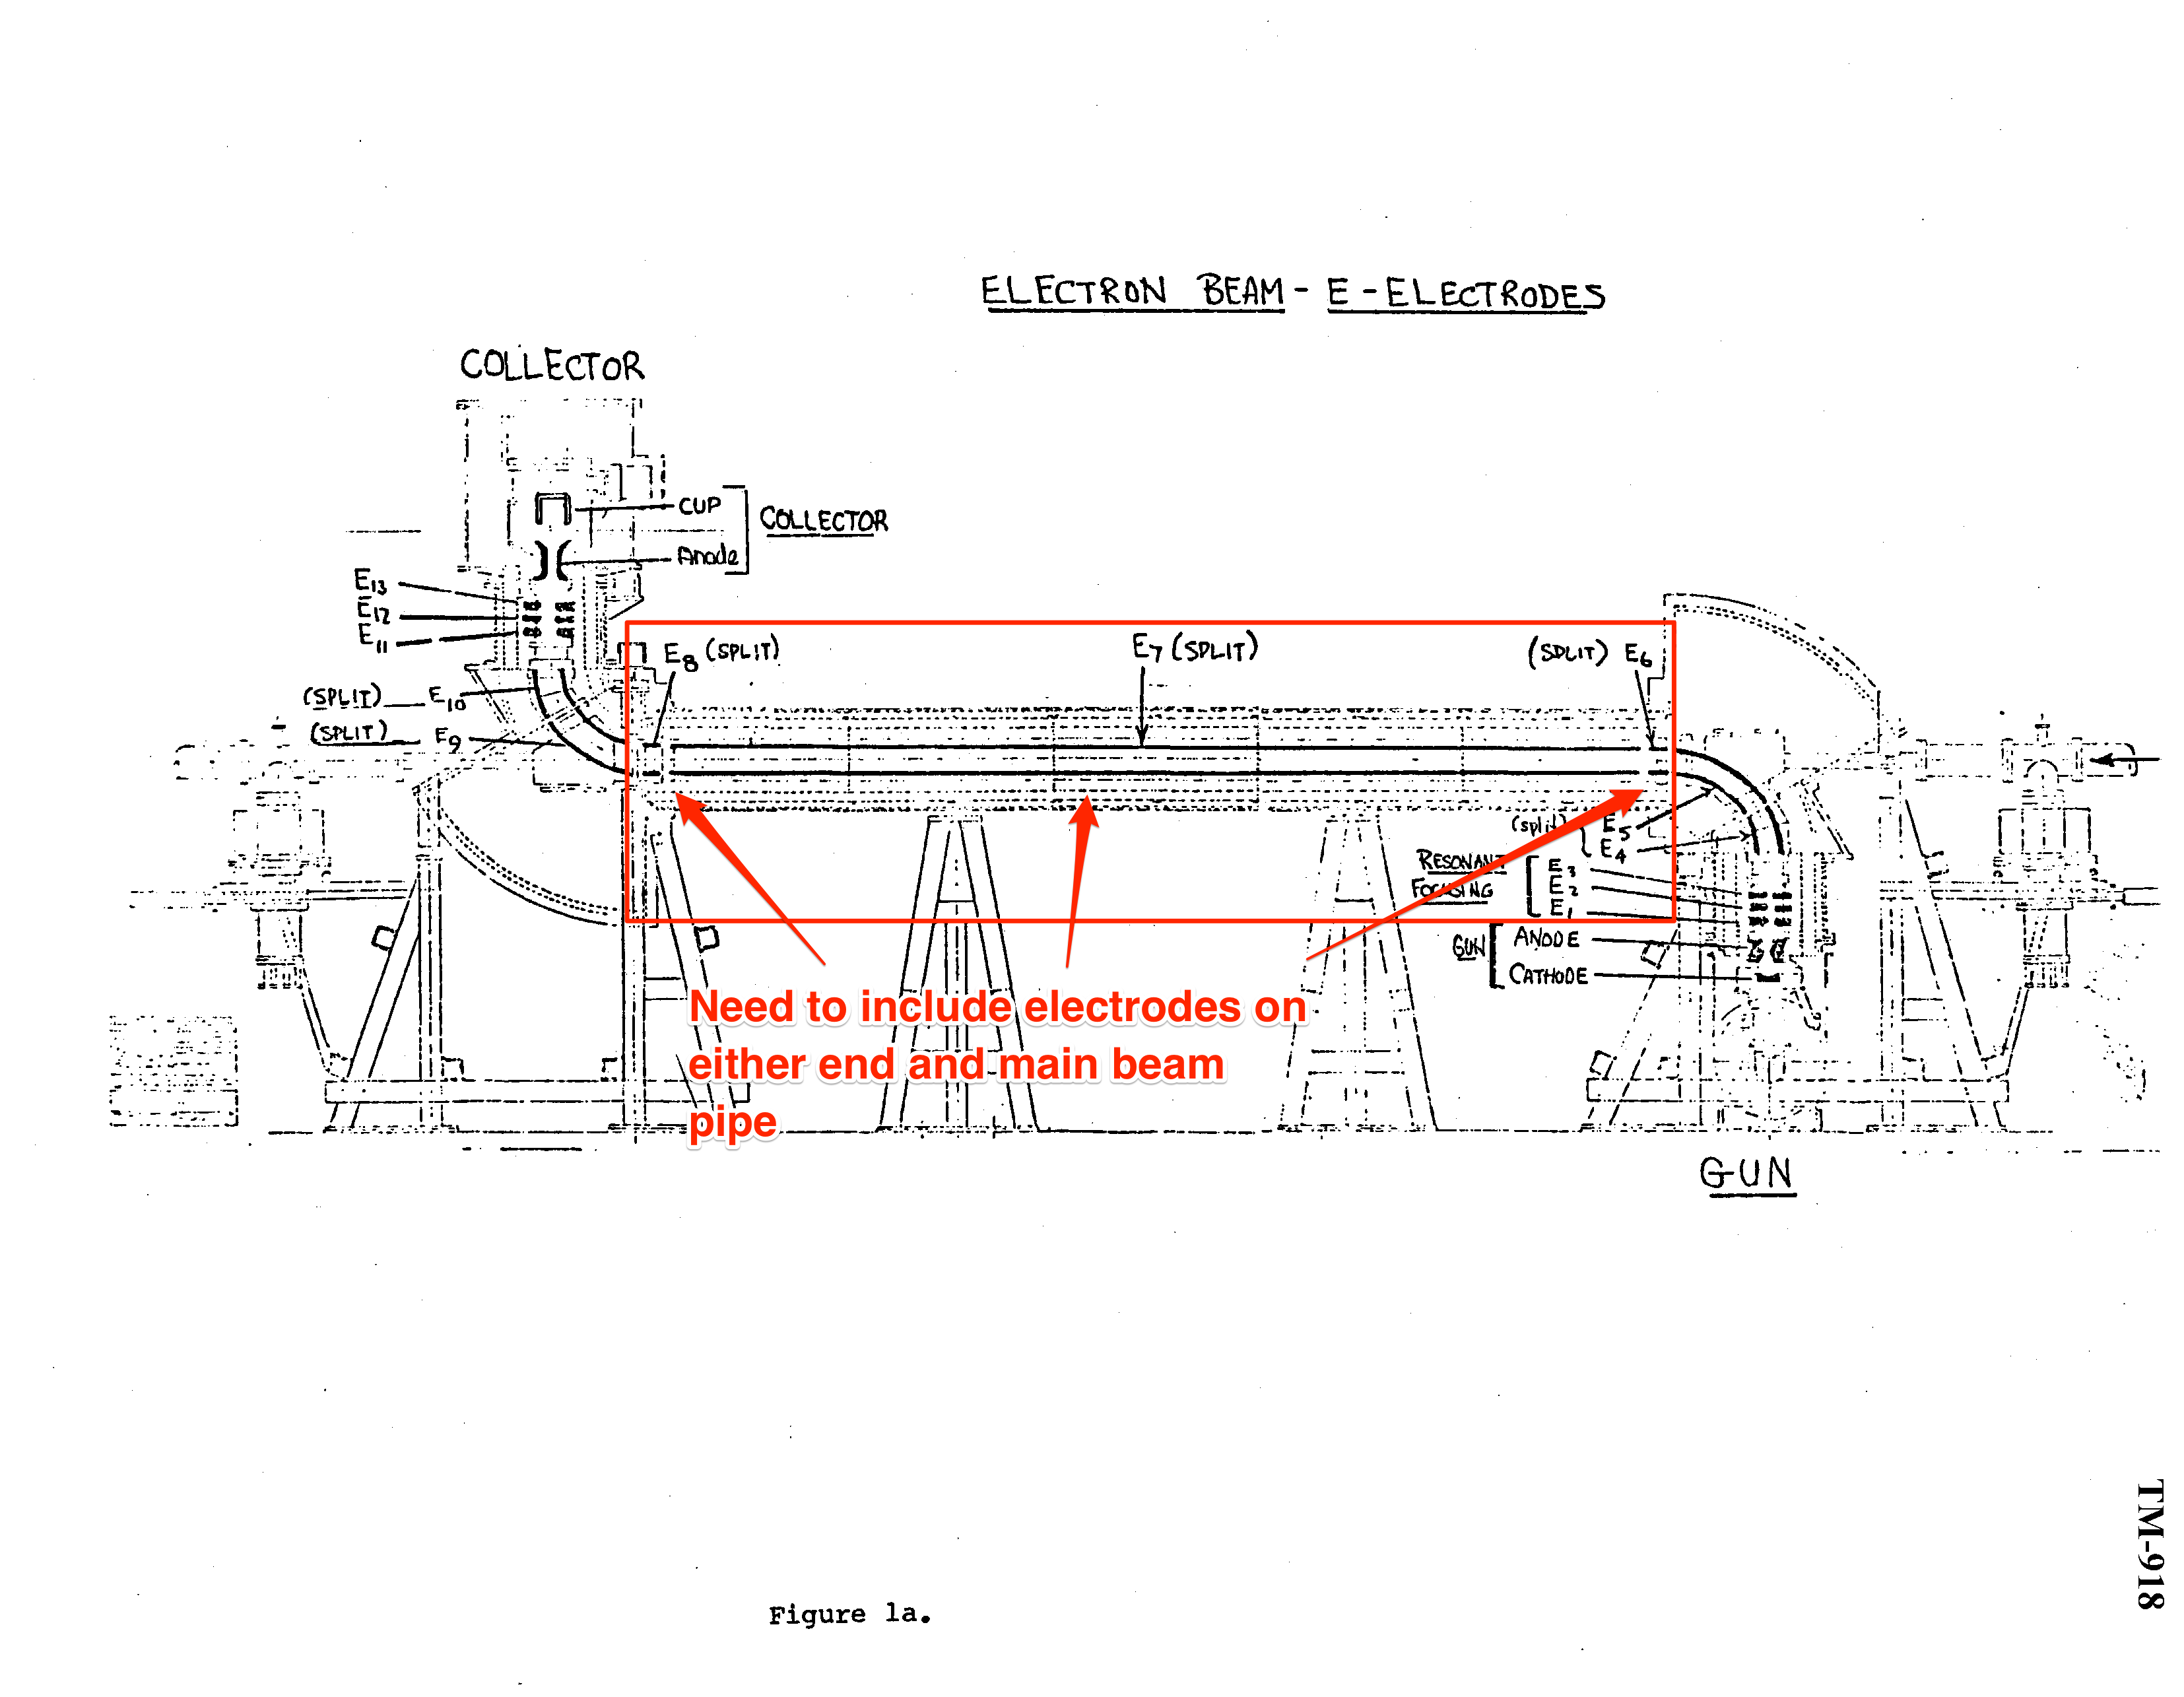

In [2]:
# Rough schematic of the Kell experimental setup
from IPython.display import Image
Image(filename="5DEC8A01-2C2C-4046-AB41-9635D3832FB8.png")

Drift region description: 5 m long (shorten to 2 m in simulation) and diameter of 0.1524 m (they use B_sol = 0.1 T, we'll use 1.0 T)

Will model 3 electrodes with central held to ground and two end electrodes at -kV to provide confinement for ionized gas

## Imports

In [3]:
%matplotlib notebook

In [4]:
import sys
import numpy as np
import h5py as h5
import pickle

from rswarp.utilities import beam_analysis
from rswarp.utilities import file_utils
from mpl_toolkits.mplot3d import Axes3D

In [5]:
import matplotlib.pyplot as plt
from matplotlib.patches import Ellipse
from scipy.stats import linregress
import matplotlib.patches as mpatches
import matplotlib as mpl
from mpl_toolkits.axes_grid1.inset_locator import inset_axes

In [6]:
from scipy.constants import c, physical_constants, m_e, e
m_e_ev = physical_constants['electron mass energy equivalent in MeV'][0]
m_e_kg = m_e

In [7]:
from cycler import cycler
colors = ["xkcd:windows blue", "xkcd:amber", "xkcd:faded green", 
          "xkcd:dusty purple", "xkcd:blood orange", "xkcd:bluish grey", 
          "xkcd:carmine", "xkcd:greenish blue", "xkcd:wine",
          "xkcd:spruce"]

# Functions
Useful functions for this notebook

In [8]:
# energy calculations
def p_to_beta(p, m=m_e_ev):
    # Assumes p in MeV/c
    p = p / (m * c)
    return p / np.sqrt(1 + p**2)
def p_to_ke(p, m=m_e_ev):
    # assumes p in MeV/c
    # returns KE in MeV
    beta = p_to_beta(p)
    gamma = 1 / np.sqrt(1 - beta**2)
    return m * gamma - m

# plotting routines
def map_colorbar(n, *args):
    n = len(full.keys())
    color = plt.cm.viridis_r(np.linspace(0.1,0.9,n)) # This returns RGBA; convert:
    hexcolor = map(lambda rgb:'#%02x%02x%02x' % (rgb[0]*255,rgb[1]*255,rgb[2]*255),
               tuple(color[:,0:-1]))
    
    for axis in args:
        axis.set_color_cycle(hexcolor)

def create_colorbar(vmin, vmax, axis, bbox_to_anchor=(1.01, 0.25, 1, 1)):
    axins = inset_axes(axis,
                       width="5%",  # width = 10% of parent_bbox width
                       height="50%",  # height : 50%
                       loc=3,
                       bbox_to_anchor=bbox_to_anchor,
                       bbox_transform=axis.transAxes,
                       borderpad=0,
                       )
    axins.text(01.25, 1.05,'Time Step', horizontalalignment='center', 
               verticalalignment='center',
               transform=axins.transAxes)
    
    norm = mpl.colors.Normalize(vmin=vmin, vmax=vmax)
    cb1 = mpl.colorbar.ColorbarBase(axins, cmap=plt.cm.viridis_r,
                                    norm=norm,
                                    orientation='vertical')

# Data Import
Import data from Warp simulation for analysis

In [9]:
path = 'diags/hdf5/'
full =  file_utils.loadparticlefiles(path)

In [10]:
step_min = min(full.keys())
step_max = max(full.keys())

# Assume uniform spacing
step_interval = step_max  / len(full.keys())

In [11]:
# Grab simulation attributes we'll need 
ff = h5.File('diags/hdf5/data00000500.h5', 'r')
beam_sw = np.average(ff['data/500/particles/Electron/weighting'])  # Macroparticle weight of beam
ion_sw = np.average(ff['data/500/particles/H2+/weighting'])  # Macroparticle weight of ions
timestep = ff['data/500'].attrs['dt']
ff.close()

## Population Calculations

### Background H2 Gas

In [12]:
P = 0.4  # Pa
T = 273.0  # K

pipe_radius = 0.1524 / 2.
pipe_length = 2.0

V = np.pi * pipe_radius**2 * pipe_length
R = 8.314
n = P / (R * T)  # in moles / m**3
n_h2 = n * 6.022e23 * (1e-2)**3  # atoms / cm**3

print("For a pressure of {} Pa the density of H2 is {} atoms/cm^3".format(P, n_h2))

For a pressure of 0.4 Pa the density of H2 is 1.06127534562e+14 atoms/cm^3


### Electron Beam

In [13]:
# electron density
electron_current = 10e-3  # A
electron_beam_radius = 1.  # cm
electron_beam_length = 200  # cm
electron_beam_velocity = 0.990813945176 * c * 1e2  # beam velocity in cm/s

n_e = electron_current / e / (electron_beam_velocity) / (np.pi * electron_beam_radius**2) # electrons / cm**3
print("Electron beam density: {} atoms / cm^3".format(n_e))

Electron beam density: 668847.216145 atoms / cm^3


## Estimate production rate
#### From theoretical Caclulation
For cross section $\sigma_{i}$, electron density $n_e$, ion density $n_0$, and electron velocity $v_e$, the ion production rate is:

$\frac{dn_i}{dt} = \sigma_{i}  n_0  n_e v_e$

In [14]:
# approximate H2 rate see h2_cross_section_calculation.ipynb for calculation of this number
h2_cross_section = 1.83998425e-20  # cm**2

dndt = h2_cross_section * n_h2 * n_e * electron_beam_velocity
print("Estimated H2 production rate: {} per cm**3 per second".format(dndt))

Estimated H2 production rate: 38795550427.0 per cm**3 per second


#### From rswarp's calculation
Taken from ln 318 in rswarp.utilities.ionization for rswarp commit 62a0962

In [15]:
dp = n_h2  # dp would be array of boolean values indicating if each particle is in the region where ionization is allowed and multiplied by local density
cross_section = h2_cross_section  # function given in warp with impact energy dependence (see h2_cross_section_calculation.ipynb for use of this)
vi = electron_beam_velocity   # Newtonian calculation of impact velocity (should be dominated by incident electrons)
dt = timestep  # time step in the simulation
ipg_ndts_js = 1.  # Stride for each species, should normally be 1 (it was when I checked it in test simulations)
stride = 100.  # Number of particles allowed to generate ionization events each time step

ncol = dp * cross_section * vi * dt * ipg_ndts_js * stride * beam_sw / ion_sw
print("Per Macroparticle ionization event probability in warp: {}".format(ncol))

Per Macroparticle ionization event probability in warp: 0.00195654158735


### Simulation Ion - electron - beam Population Growth

<IPython.core.display.Javascript object>


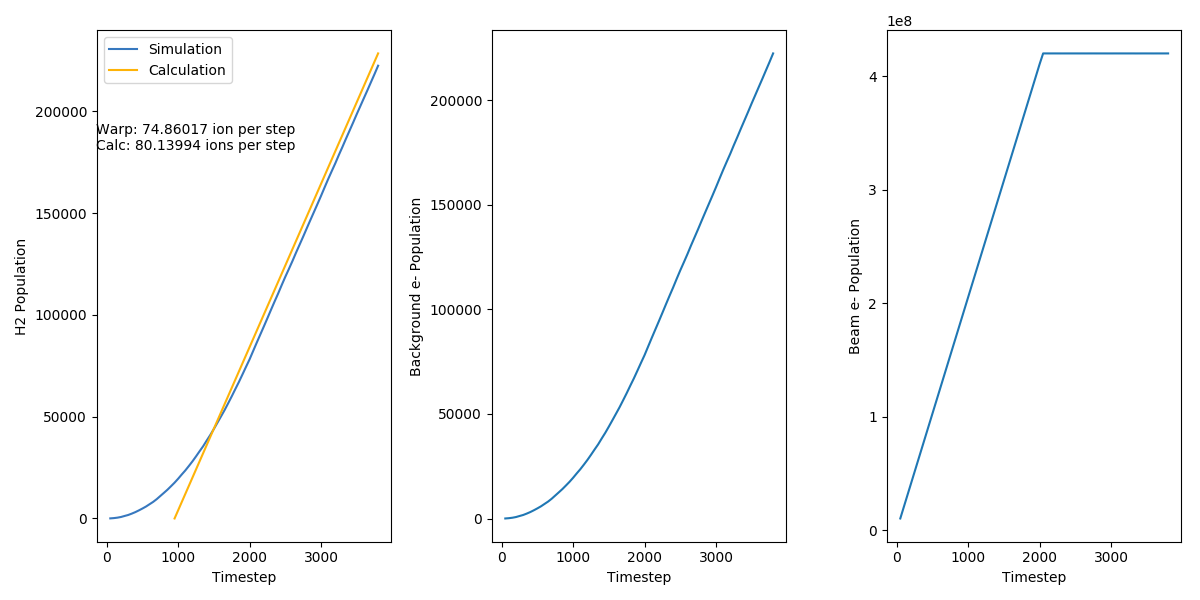

In [16]:
ions, [ax1, ax2, ax3] = plt.subplots(1, 3, figsize=(12, 6))
ax1.set_prop_cycle(cycler('color', colors))

h2_pop = []
em_pop = []
beam_pop = []

for step in sorted(full.keys()):
    h2_pop.append(full[step]['H2+'][:, 0].size)
    em_pop.append(full[step]['emitted e-'][:, 0].size)
    beam_pop.append(full[step]['Electron'][:, 0].size)

# linear fit to find ion production rate. Taken after several timesteps to let electron beam fill most of the domain.
# will be in terms of real number of ions / time step
sim_slope, sim_offset, _, _, _ = linregress(np.arange(step_min, step_max + 1, step_interval)[18:], np.array(h2_pop)[18:] * ion_sw)

# real number of ions / time step based on estimate above
calc_slope = dndt * timestep * (np.pi * electron_beam_radius**2) * electron_beam_length

ax1.annotate("Warp: {:.5f} ion per step\nCalc: {:.5f} ions per step".format(sim_slope, calc_slope), xy=(0.08, 0.75), xycoords='figure fraction')

# H2 ions vs time in Warp
ax1.plot(np.arange(step_min, step_max + 1, step_interval), np.array(h2_pop) * ion_sw,
         label="Simulation")

# Estimated H2 ion population from calculation. Doesn't account for beam being injected, resulting in incorrect offset.
ax1.plot(np.arange(step_min, step_max + 1, step_interval)[18:], 
         calc_slope * np.arange(step_min, step_max + 1, step_interval)[18:] - calc_slope * np.arange(step_min, step_max + 1, step_interval)[18],
         label="Calculation")
ax1.set_xlabel("Timestep")
ax1.set_ylabel("H2 Population")
ax1.legend()

# Electron population from ionization events in Warp
ax2.plot(np.arange(step_min, step_max + 1, step_interval), np.array(em_pop) * ion_sw )
ax2.set_xlabel("Timestep")
ax2.set_ylabel("Background e- Population")

# Injected electron beam population in Warp
ax3.plot(np.arange(step_min, step_max + 1, step_interval), np.array(beam_pop) * beam_sw)
ax3.set_xlabel("Timestep")
ax3.set_ylabel("Beam e- Population")

plt.tight_layout()
plt.show()

Perfect agreement should not be expected in ion production rate over short time scales when macroparticle weight > 1 is used due to low macroparticle statistics. Very good agreement is seen in long term simulations.

### Ions

In [17]:
h2_weight_kg = 3.3444946e-27
h2_weight_ev = 1876.124

<IPython.core.display.Javascript object>


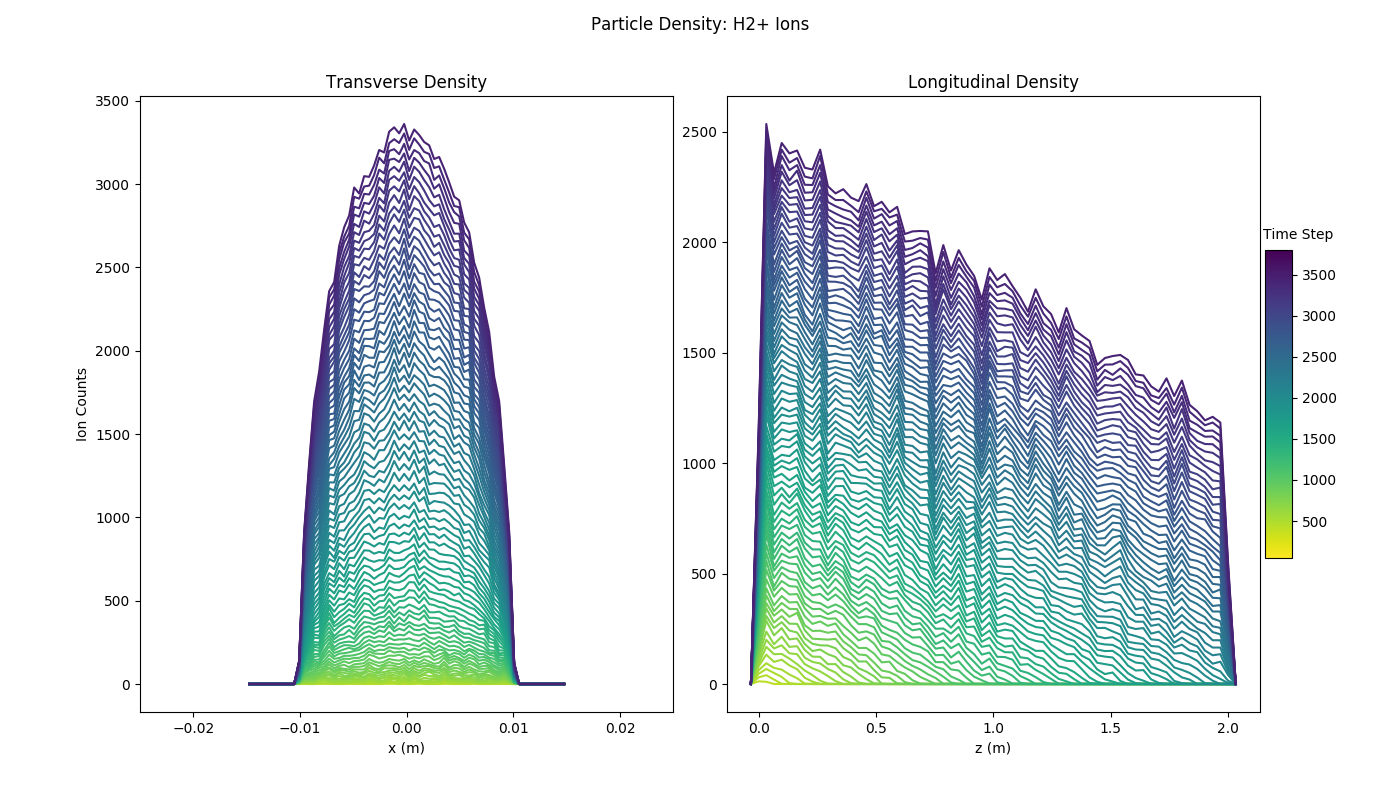

/usr/local/lib/python2.7/site-packages/ipykernel_launcher.py:21: MatplotlibDeprecationWarning: The set_color_cycle function was deprecated in version 1.5. Use `.set_prop_cycle` instead.


In [18]:
ion_profile, [ax1, ax2] = plt.subplots(1, 2, figsize=(14, 8))

plt.suptitle('Particle Density: H2+ Ions')

n = len(full.keys())
map_colorbar(n, ax1, ax2)

ax1.set_title("Transverse Density")
ax2.set_title("Longitudinal Density")

for step in sorted(full.keys()):
    counts, edges = np.histogram(full[step]['H2+'][:, 0], 64, range=(-0.015, 0.015))
    centers = []
    for i in range(edges.size - 1):
        centers.append((edges[i + 1] + edges[i]) / 2.)
    test = ax1.plot(centers, counts, label='{}'.format(step))
    
    counts, edges = np.histogram(full[step]['H2+'][:, 4], 64, range=(-0.05, 2.05))
    centers = []
    for i in range(edges.size - 1):
        centers.append((edges[i + 1] + edges[i]) / 2.)
    ax2.plot(centers, counts, label='{}'.format(step))

ax1.set_xlabel('x (m)')
ax1.set_ylabel('Ion Counts')
ax2.set_xlabel('z (m)')
ax1.set_xlim(-0.025, 0.025)

# Make colorbar
create_colorbar(min(full.keys()), max(full.keys()), ax2)

# clean up plot positions
plt.subplots_adjust(left=0.1, wspace=0.1)

# ion_profile.savefig('profile_ions.pdf')
plt.show()

### Ion kinetic energy vs z

<IPython.core.display.Javascript object>


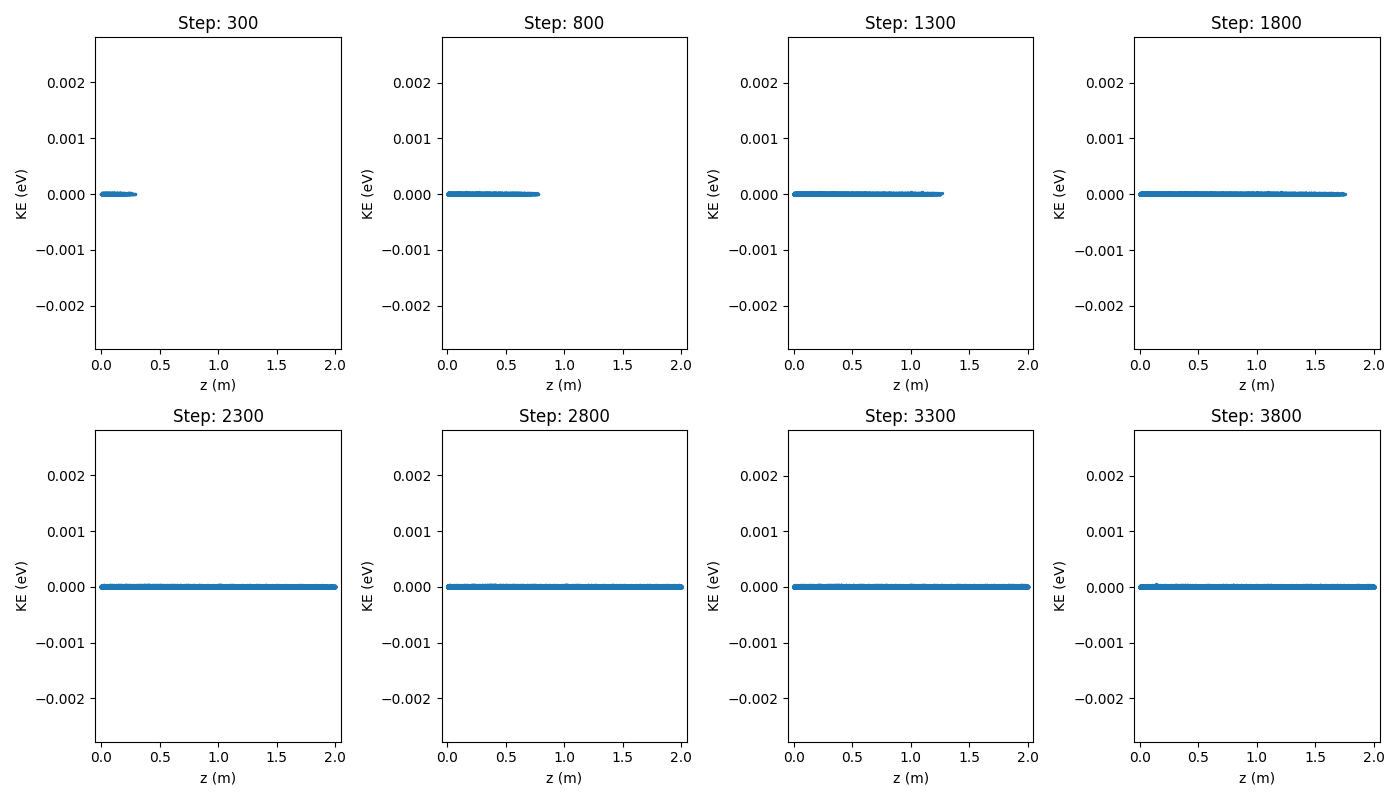

In [21]:
ion_energy_profile, ax = plt.subplots(2, 4, figsize=(14, 8))

intervals = sorted(full.keys())[::-len(full.keys()) // ax.size]
for fig, step in zip(ax.flat, intervals[::-1]):
    fig.set_title("Step: {}".format(step))
    full[step]['emitted e-'][:, 0]
    
    px = full[step]['H2+'][:, 1] * c / e
    py = full[step]['H2+'][:, 3] * c / e
    pz = full[step]['H2+'][:, 5] * c / e
    pt = np.sqrt(px**2 + py**2 + pz**2)
    ke = p_to_ke(pt, m=h2_weight_ev)
    fig.scatter(full[step]['H2+'][:, 4], 
                ke, 
                s=2)
    
    fig.set_xlabel('z (m)')
    fig.set_ylabel('KE (eV)')
#     fig.set_yscale('log')
    fig.set_xlim(-0.05, 2.05)
    #fig.set_ylim(np.min(ke) * 0.9999, np.max(ke) * 1.55)


plt.tight_layout()
plt.show()

### Testing that Ions follow thermal distribution

<IPython.core.display.Javascript object>


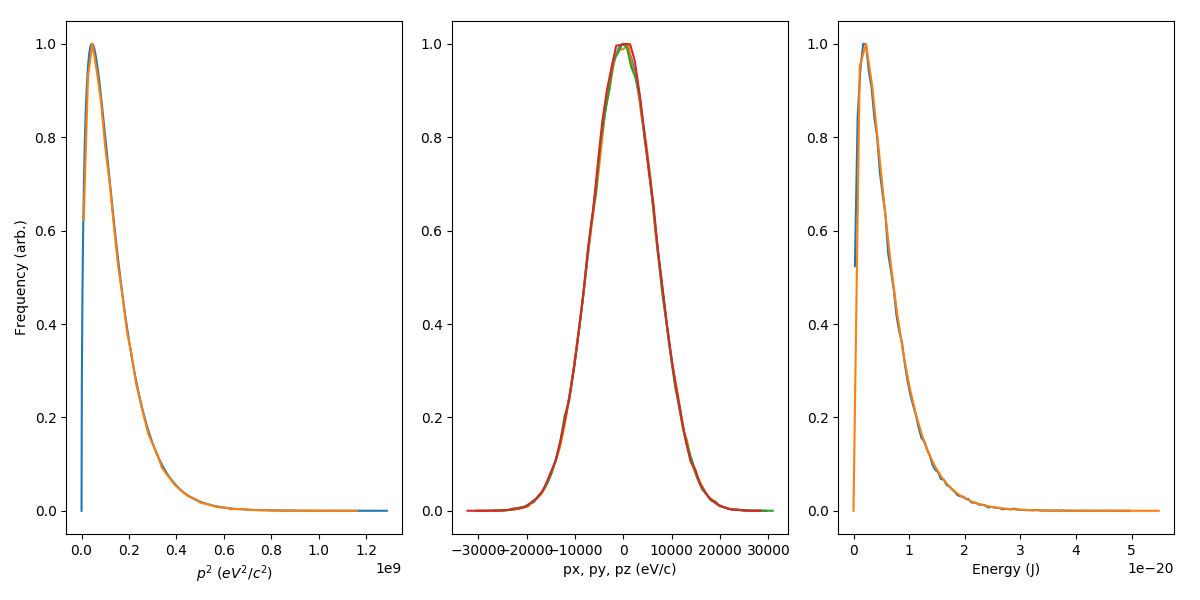

In [22]:
ion_momentum_distribution, [ax1, ax2, ax3] = plt.subplots(1, 3, figsize=(12, 6))

step = step_max
px = full[step]['H2+'][:, 1] * c / e
py = full[step]['H2+'][:, 3] * c / e
pz = full[step]['H2+'][:, 5] * c / e
pt = px**2 + py**2 + pz**2

def mb_p(psqrd, m, T):
    k = 8.6173303e-5
    return np.sqrt(2 / np.pi) * (m * k * T)**(-3 / 2.) * np.sqrt(psqrd) * np.exp(-psqrd / (2 * m * k * T))

# Total Momentum
pvals = np.linspace(0, 1.1 * np.max(pt), 1000)
p_theoretical =  mb_p(pvals, 1877780247.4017024, 273)
ax1.plot(pvals, p_theoretical / np.max(p_theoretical))

counts, edges = np.histogram(pt, 64)
centers = []
for i in range(edges.size - 1):
    centers.append((edges[i + 1] + edges[i]) / 2.)
ax1.plot(centers, counts / np.max(counts.astype('float')), label='{}'.format(step))

ax1.set_xlabel("$p^2$ ($eV^2/c^2$)")
ax1.set_ylabel("Frequency (arb.)")

# Momentum Component
def mb_px(p, m, T):
    k = 8.6173303e-5
    return (2 * np.pi * m * k * T)**(-1.5) * np.exp(-p**2 / (2 * m * k * T))
pxvals = np.linspace(np.min(px), np.max(px), 1000)
px_theoretical = mb_px(pxvals, 1877780247.4017024, 273)
ax2.plot(pxvals, px_theoretical / np.max(px_theoretical))
for pc in [px, py, pz]:
    counts, edges = np.histogram(pc, 64)
    centers = []
    for i in range(edges.size - 1):
        centers.append((edges[i + 1] + edges[i]) / 2.)
    ax2.plot(centers, counts / np.max(counts.astype('float')), label='{}'.format(step))
ax2.set_xlabel("px, py, pz (eV/c)")
# ax2.hist(np.random.normal(0., np.sqrt(2 * )))
plt.tight_layout()

# Energy 
# gamma ~ 1 so just use v*gamma
vg = np.sqrt(full[step]['H2+'][:, 1]**2 + full[step]['H2+'][:, 3]**2 + full[step]['H2+'][:, 5]**2) / 3.34744720006548e-27
E = 0.5 * 3.34744720006548e-27 * vg**2

def mb_energy(E, T):
    # Using SI
    k = 1.38064852e-23
    return 2 * np.sqrt(E / np.pi) * (1 / (k * T))**(1.5) * np.exp(-E / (k * T))

counts, edges = np.histogram(E, 100)
centers = []
for i in range(edges.size - 1):
    centers.append((edges[i + 1] + edges[i]) / 2.)
ax3.plot(centers, counts / np.max(counts.astype('float')), label='{}'.format(step))

Evals = np.linspace(0., 1.1 * np.max(E))
E_theoretical = mb_energy(Evals, 273)
ax3.plot(Evals, E_theoretical / np.max(E_theoretical))
ax3.set_xlabel("Energy (J)")
plt.show()

### Background Electrons

<IPython.core.display.Javascript object>


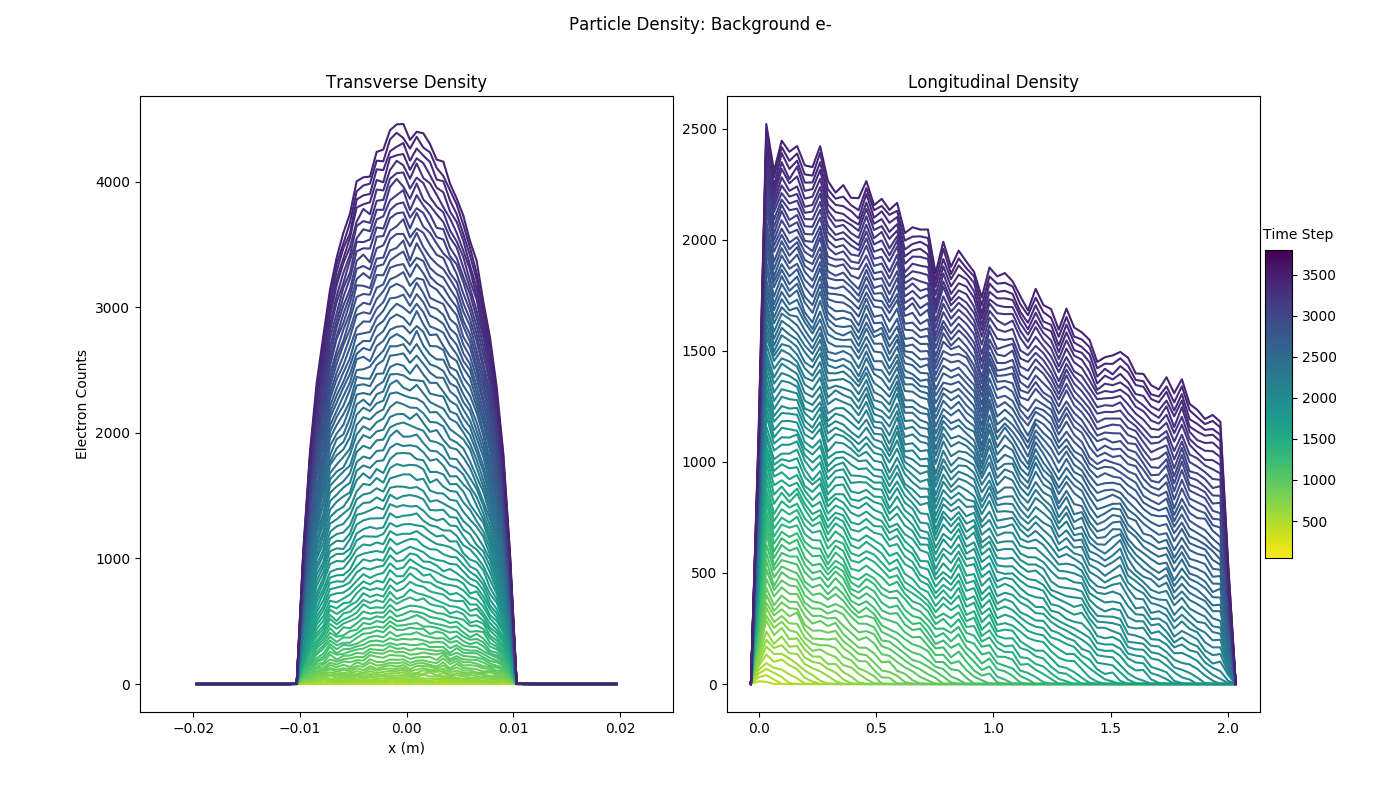

/usr/local/lib/python2.7/site-packages/ipykernel_launcher.py:21: MatplotlibDeprecationWarning: The set_color_cycle function was deprecated in version 1.5. Use `.set_prop_cycle` instead.


In [23]:
electron_profile, [ax1, ax2] = plt.subplots(1, 2, figsize=(14, 8))
# ax1.set_prop_cycle(cycler('color', colors))

n = len(full.keys())
map_colorbar(n, ax1, ax2)

plt.suptitle('Particle Density: Background e-')

ax1.set_title("Transverse Density")
ax2.set_title("Longitudinal Density")

for step in sorted(full.keys()):
    counts, edges = np.histogram(full[step]['emitted e-'][:, 0], 64, range=(-0.02, 0.02))
    centers = []
    for i in range(edges.size - 1):
        centers.append((edges[i + 1] + edges[i]) / 2.)
    ax1.plot(centers, counts, label='{}'.format(step))
    
    counts, edges = np.histogram(full[step]['emitted e-'][:, 4], 64, range=(-0.05, 2.05))
    centers = []
    for i in range(edges.size - 1):
        centers.append((edges[i + 1] + edges[i]) / 2.)
    ax2.plot(centers, counts, label='{}'.format(step))
    
ax1.set_xlabel('x (m)')
ax1.set_ylabel('Electron Counts')

# Make colorbar
create_colorbar(min(full.keys()), max(full.keys()), ax2)

ax1.set_xlim(-0.025, 0.025)

# clean up plot positions
plt.subplots_adjust(left=0.1, wspace=0.1)

# electron_profile.savefig('profile_electrons.pdf')
plt.show()

<IPython.core.display.Javascript object>


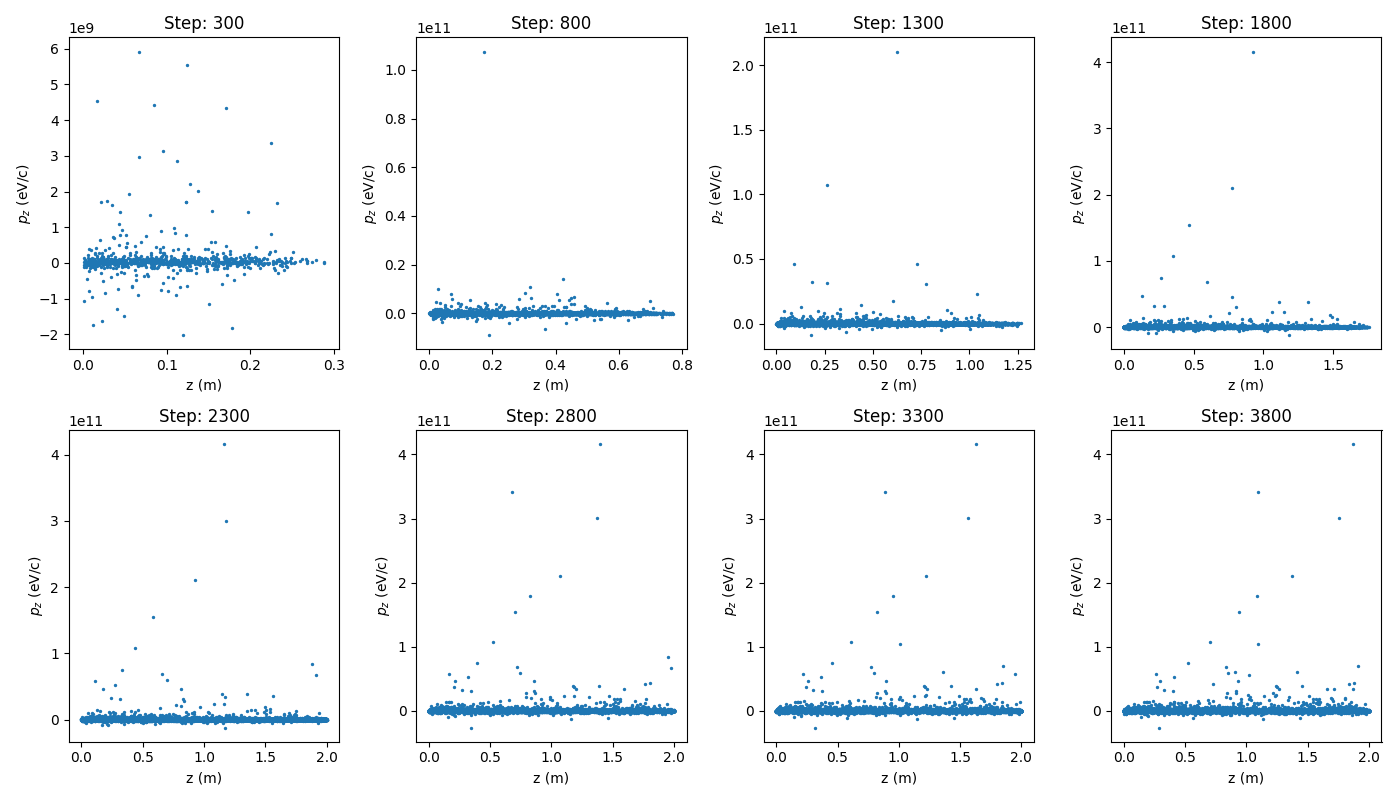

In [24]:
electron_energy, ax = plt.subplots(2, 4, figsize=(14, 8))

intervals = sorted(full.keys())[::-len(full.keys()) // ax.size]
for fig, step in zip(ax.flat, intervals[::-1]):
    fig.set_title("Step: {}".format(step))
    full[step]['emitted e-'][:, 0]
    
    px = full[step]['emitted e-'][:, 1] * c / e
    py = full[step]['emitted e-'][:, 3] * c / e
    pz = full[step]['emitted e-'][:, 5] * c / e
    pt = np.sqrt(px**2 + py**2 + pz**2)

    fig.scatter(full[step]['emitted e-'][:, 4], 
                pz * 1e6, 
                s=2)
    
    fig.set_xlabel('z (m)')
    fig.set_ylabel('$p_z$ (eV/c)')

plt.tight_layout()

electron_energy.savefig('energy-z_electrons.png')
plt.show()

In [26]:
# background electron velocities
vx = full[1000]['emitted e-'][:, 1] * h2_weight_ev / h2_weight_kg
vy = full[1000]['emitted e-'][:, 3] * h2_weight_ev / h2_weight_kg
vt = np.sqrt(vx**2 + vy**2)
vmax, vmin = p_to_beta(np.max(vt), m=h2_weight_ev), p_to_beta(np.min(vt), m=h2_weight_ev)
imax, imin = np.argmax(vt), np.argmin(vt)
print "max vt: {}, vl: {}".format(vmax, p_to_beta(full[1000]['emitted e-'][imax, 5] * h2_weight_ev / h2_weight_kg, m=h2_weight_ev))
print "min vt: {}, vl: {}".format(vmin, p_to_beta(full[1000]['emitted e-'][imin, 5] * h2_weight_ev / h2_weight_kg, m=h2_weight_ev))

max vt: 1.08901034577e-05, vl: -1.60506664979e-06
min vt: 2.48211495852e-07, vl: -1.63018872553e-07


In [27]:
# beam electron velocities
vx = full[1000]['Electron'][:, 1] * m_e_ev / m_e_kg
vy = full[1000]['Electron'][:, 3] * m_e_ev / m_e_kg
vt = np.sqrt(vx**2 + vy**2)
vmax, vmin = p_to_beta(np.max(vt)), p_to_beta(np.min(vt))
imax, imin = np.argmax(vt), np.argmin(vt)
print "max vt: {}, vl: {}".format(vmax, p_to_beta(full[1000]['Electron'][imax, 5] * m_e_ev / m_e_kg))
print "min vt: {}, vl: {}".format(vmin, p_to_beta(full[1000]['Electron'][imin, 5] * m_e_ev / m_e_kg))

max vt: 0.000251677070509, vl: 0.990804169186
min vt: 9.3157957023e-08, vl: 0.990804168898


### Analyzing Electron Beam

<IPython.core.display.Javascript object>


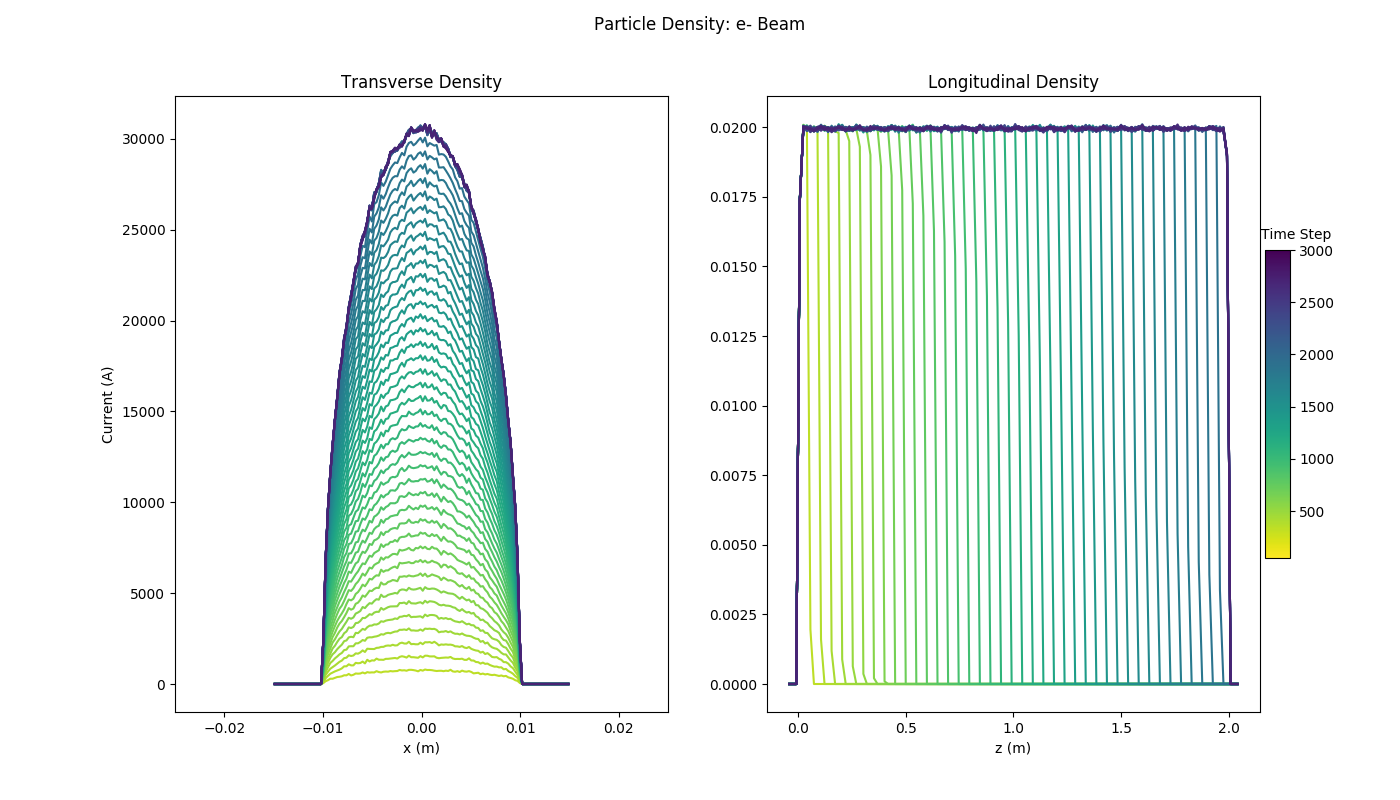

/home/vagrant/.pyenv/versions/2.7.14/envs/py2/lib/python2.7/site-packages/ipykernel_launcher.py:21: MatplotlibDeprecationWarning: The set_color_cycle function was deprecated in version 1.5. Use `.set_prop_cycle` instead.


In [28]:
beam_profile, [ax1, ax2] = plt.subplots(1, 2, figsize=(14, 8))
n = len(full.keys())
map_colorbar(n, ax1, ax2)

plt.suptitle('Particle Density: e- Beam')

ax1.set_title("Transverse Density")
ax2.set_title("Longitudinal Density")

for step in sorted(full.keys()):
    counts, edges = np.histogram(full[step]['Electron'][:, 0], 128, range=(-0.015, 0.015))
    centers = []
    for i in range(edges.size - 1):
        centers.append((edges[i + 1] + edges[i]) / 2.)
    ax1.plot(centers, counts, label='{}'.format(step))
    
    counts, edges = np.histogram(full[step]['Electron'][:, 4], 128, range=(-0.05, 2.05))
    dz = 2.1 / len(counts)
    current = 215. * dz * 1e4 / electron_beam_velocity
    centers = []
    for i in range(edges.size - 1):
        centers.append((edges[i + 1] + edges[i]) / 2.)
    ax2.plot(centers, counts * current, label='{}'.format(step))

ax1.set_xlabel('x (m)')
ax1.set_ylabel('Electron Counts')

ax2.set_xlabel('z (m)')
ax1.set_ylabel('Current (A)')

# Make colorbar
create_colorbar(min(full.keys()), max(full.keys()), ax2)

ax1.set_xlim(-0.025, 0.025)

#beam_profile.savefig('profile_beam.pdf')

plt.show()

# Fields
Ion populations are far too low to observe changes in fields but these should be useful eventually

In [29]:
step0 = 1000
step1 = 3000
field_file_0 = 'diags/fields/electric/data0{}.h5'.format(step0)
field_file = 'diags/fields/electric/data0{}.h5'.format(step1)
fields_0 = h5.File(field_file_0, 'r')
fields = h5.File(field_file, 'r')

In [30]:
for key in fields['data/{}/meshes/E'.format(step1)].keys():
    print key

r
t
z


In [31]:
phi_0 = fields_0['data/{}/meshes/phi'.format(step0)]
efield_0 = fields_0['data/{}/meshes/E'.format(step0)]

phi_1 = fields['data/{}/meshes/phi'.format(step1)]
efield_1 = fields['data/{}/meshes/E'.format(step1)]

### Potential on x vs z

<IPython.core.display.Javascript object>


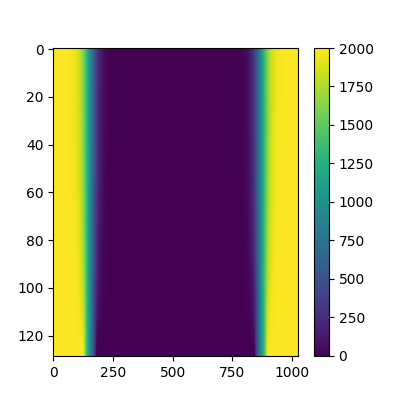

In [32]:
potential1, ax1 = plt.subplots(1, 1, figsize=(4, 4))

a1 = ax1.imshow(phi_0[0,:,:], aspect=10)
plt.colorbar(a1)

plt.show()

### Potential vs z at x=xmax//2

<IPython.core.display.Javascript object>


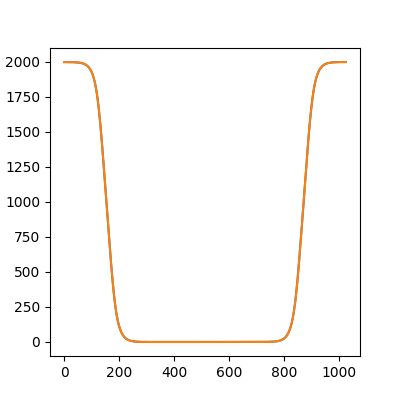

In [33]:
potential2, ax1 = plt.subplots(1, 1, figsize=(4, 4))

a1 = ax1.plot(phi_0[0,56,:])
a2 = ax1.plot(phi_1[0,56,:])

plt.show()

### Radial component of electric field 

<IPython.core.display.Javascript object>


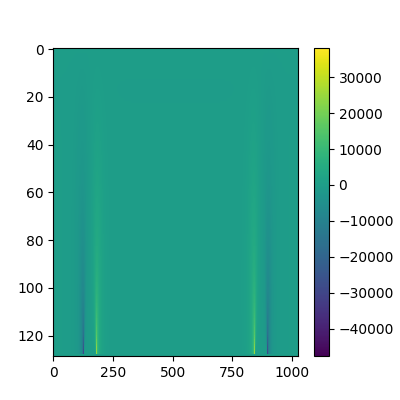

In [34]:
efield, ax1 = plt.subplots(1, 1, figsize=(4, 4))

a1 = ax1.imshow(efield_1['r'][0,:,:], aspect=10)
plt.colorbar(a1)

plt.show()

### Potential vs r at z=zmax//2

<IPython.core.display.Javascript object>


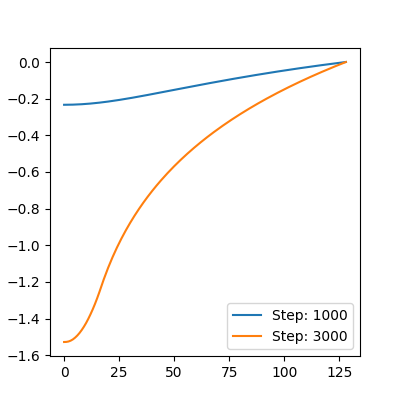

In [35]:
potential_profile, ax1 = plt.subplots(1, 1, figsize=(4, 4))

a1 = ax1.plot(phi_0[0,:,512], label='Step: {}'.format(step0))
a2 = ax1.plot(phi_1[0,:,512], label='Step: {}'.format(step1))

plt.legend()
plt.show()